<a href="https://colab.research.google.com/github/jw00oo1/Dacon/blob/main/AI%EC%95%BC%2C_%EC%A7%84%EC%A7%9C_%EB%89%B4%EC%8A%A4%EB%A5%BC_%EC%B0%BE%EC%95%84%EC%A4%98!.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import sklearn
from tensorflow import keras

In [ ]:
print(os.listdir())

['.config', 'drive', 'sample_data']


In [ ]:
file_dir = "/content/drive/MyDrive/Dacon/AInews"
train_csv = pd.read_csv(file_dir + "/news_train.csv")
test_csv = pd.read_csv(file_dir + "/news_test.csv")
submission_csv = pd.read_csv(file_dir + "/sample_submission.csv")

print(train_csv.shape)
print(test_csv.shape)

(118745, 6)
(142565, 6)


In [ ]:
train_csv.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


#Dacon-EDA

###date

In [ ]:
from datetime import datetime

In [ ]:
#data 넘길 때, 단순 복제로 넘어가므로 복사본 넘겨야함, 컬럼 이름 다르면 안됌
tmp = pd.DataFrame(data=train_csv['date'].copy(), columns=['date'])

In [ ]:
tmp['date'] = tmp['date'].apply(lambda x: str(x))

In [ ]:
tmp['date'] = pd.to_datetime(tmp['date'], format='%Y%m%d')

In [ ]:
tmp['year'] = tmp['date'].dt.year
tmp['month'] = tmp['date'].dt.month
tmp['day'] = tmp['date'].dt.day

In [ ]:
tmp['info'] = train_csv['info'].copy()

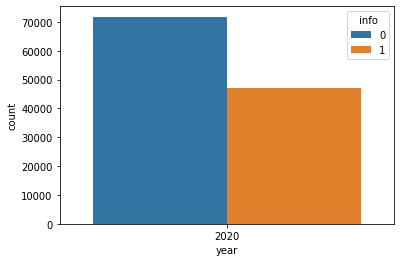

In [ ]:
sns.countplot(data = tmp, x='year', hue='info')

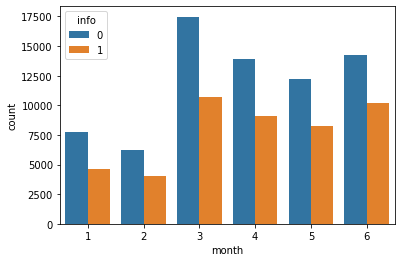

In [ ]:
sns.countplot(data=tmp, x='month', hue = 'info')

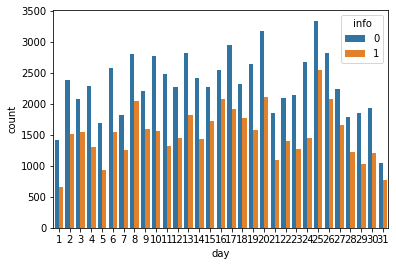

In [ ]:
sns.countplot(data = tmp, x='day', hue = 'info')

###title

In [ ]:
#가짜 뉴스와 진짜 뉴스는 겹치는 제목이 약 93%로 상당함 (set의 교집합)
#nunique -> unique한 값의 개수
len(set(train_csv[train_csv['info']==1]['title'].unique()) & set(train_csv[train_csv['info']==0]['title'].unique())) / train_csv['title'].nunique()

0.9368450082735797

In [ ]:
tmp = pd.concat([tmp, train_csv['title']], axis=1)

In [ ]:
tmp['title_len'] = tmp['title'].apply(lambda x: len(x))

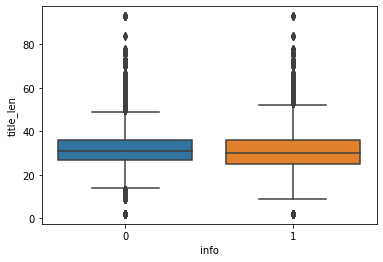

In [ ]:
sns.boxplot(data = tmp, y='title_len', x='info')

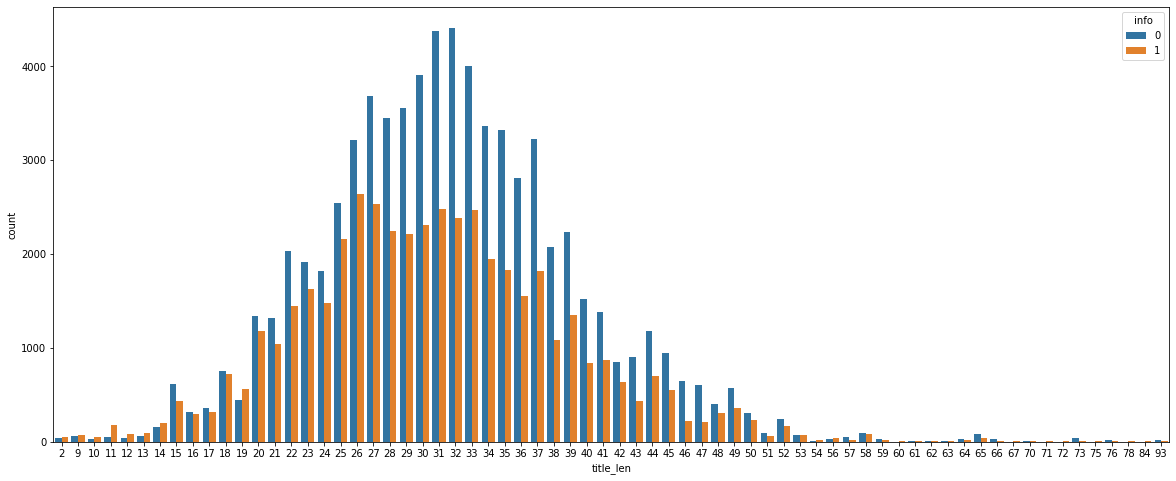

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(data=tmp, x='title_len', hue='info')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


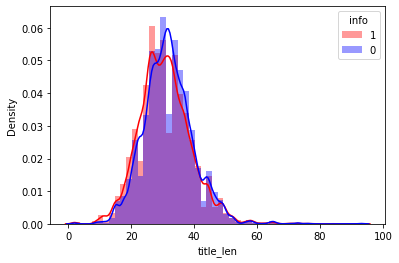

In [ ]:
sns.distplot(tmp[tmp['info']==1]['title_len'], color='red', label='1')
sns.distplot(tmp[tmp['info']==0]['title_len'], color='blue', label='0')
plt.legend(title='info')

###content

In [ ]:
#가짜 뉴스의 내용과 진짜 뉴스는 겹치는 내용이 거의 없음
len(set(train_csv[train_csv['info']==1]['content'].unique()) & set(train_csv[train_csv['info']==0]['content'].unique())) / train_csv['content'].nunique()

6.498992656138298e-05

In [ ]:
n_fake = train_csv[train_csv['info'] == 1]['content'].nunique() / train_csv['content'].nunique()
n_true = train_csv[train_csv['info'] == 0]['content'].nunique() / train_csv['content'].nunique()

print(f'{n_fake:3f} + {n_true:3f} = {n_fake+n_true:3f}')

0.125517 + 0.874548 = 1.000065


In [ ]:
train_csv['content_leng'] = train_csv['content'].apply(lambda x: len(x))

In [ ]:
Q1 = train_csv[train_csv['info'] == 1].describe(include='all')['content_leng']['25%']
Q3 = train_csv[train_csv['info'] == 1].describe(include='all')['content_leng']['75%']
IQR = Q3 - Q1
mxm = Q3 + 1.5 * IQR
mxm

57.0

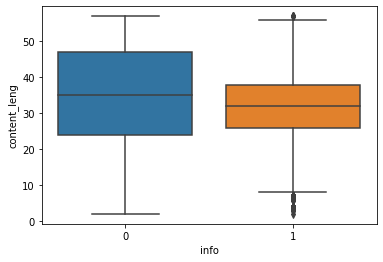

In [ ]:
sns.boxplot(data = train_csv[train_csv['content_leng'] <= mxm], y='content_leng', x='info')

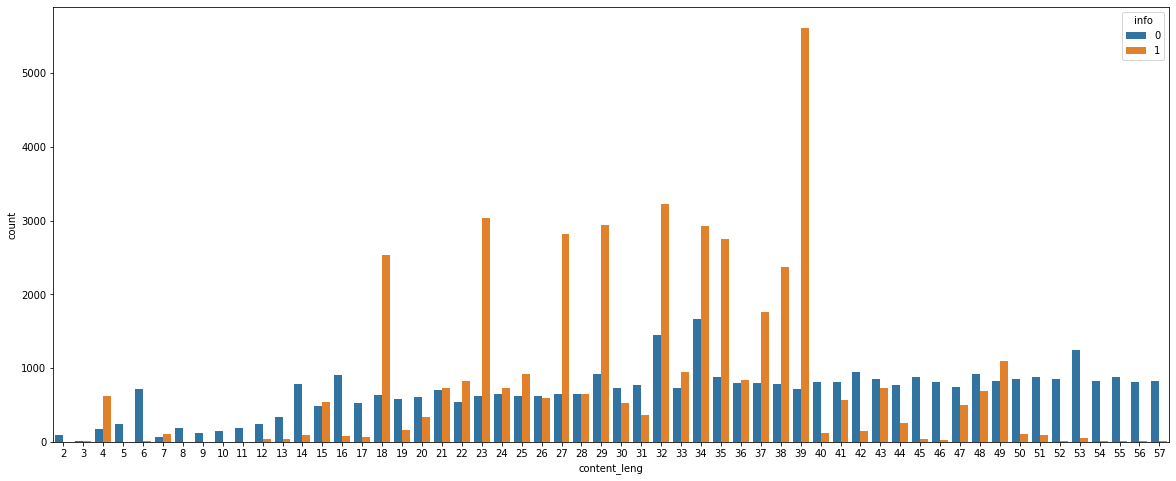

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(data = train_csv[train_csv['content_leng'] <= mxm], x = 'content_leng', hue = 'info')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


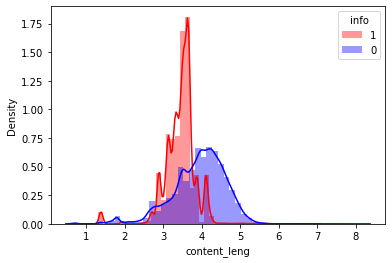

In [ ]:
sns.distplot(np.log(train_csv[train_csv['info'] == 1]['content_leng']), color = 'red', label = '1')
sns.distplot(np.log(train_csv[train_csv['info'] == 0]['content_leng']), color = 'blue', label = '0')
plt.legend(title = 'info')

###ord

##### ord가 작을 때는 0과 1의 차이가 크지만 커질수록 그 차이가 미미해짐

In [ ]:
train_csv.describe(include='all')['ord']

count     118745.000000
unique              NaN
top                 NaN
freq                NaN
mean          39.125614
std           45.138605
min            1.000000
25%            9.000000
50%           21.000000
75%           56.000000
max          396.000000
Name: ord, dtype: float64

In [ ]:
train_csv[train_csv['info'] == 1].describe(include='all')['ord']

count     46932.000000
unique             NaN
top                NaN
freq               NaN
mean         46.052416
std          43.153748
min           1.000000
25%          15.000000
50%          33.000000
75%          65.000000
max         396.000000
Name: ord, dtype: float64

In [ ]:
train_csv[train_csv['info'] == 0].describe(include='all')['ord']

count     71813.000000
unique             NaN
top                NaN
freq               NaN
mean         34.598736
std          45.827948
min           1.000000
25%           6.000000
50%          15.000000
75%          48.000000
max         374.000000
Name: ord, dtype: float64

In [ ]:
Q1 = train_csv[train_csv['info'] == 1].describe(include='all')['ord']['25%']
Q3 = train_csv[train_csv['info'] == 1].describe(include='all')['ord']['75%']
IQR = Q3 - Q1
mxm = Q3 + 1.5 * IQR
mxm

140.0

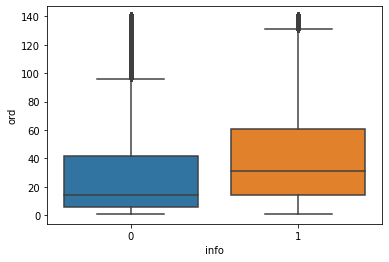

In [ ]:
sns.boxplot(data = train_csv[train_csv['ord'] <= mxm], y = 'ord', x = 'info')

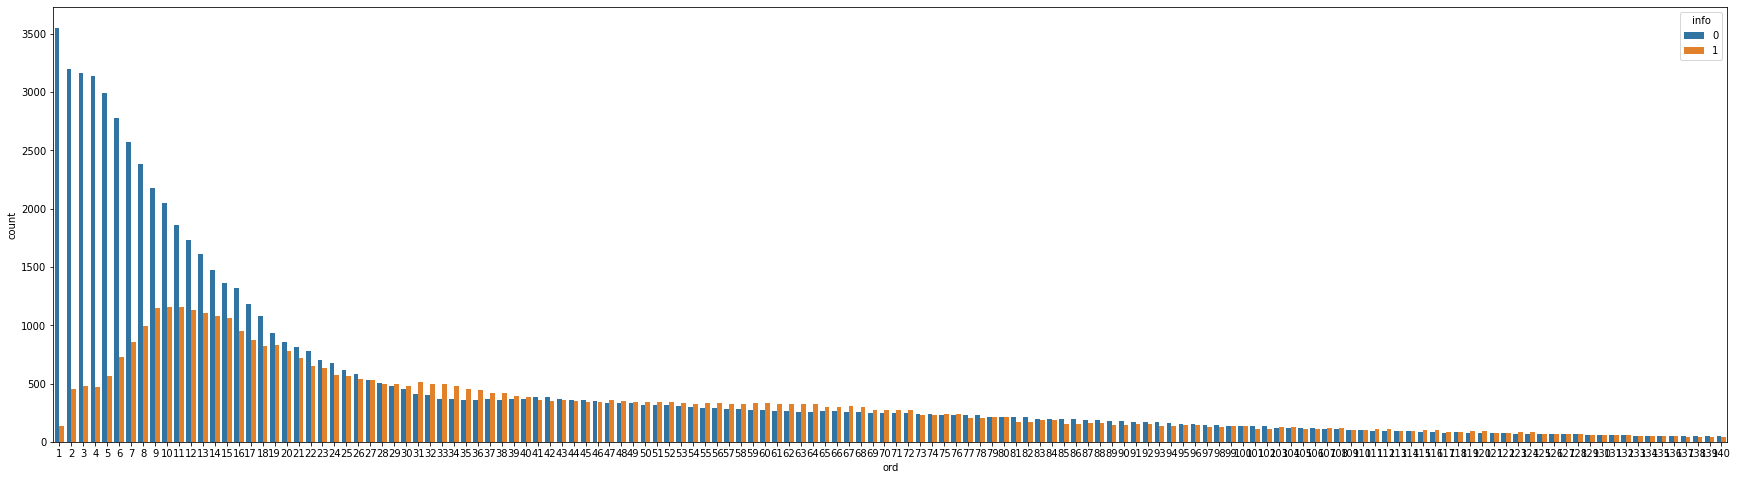

In [ ]:
plt.figure(figsize=(30,8))
sns.countplot(data = train_csv[train_csv['ord'] <= mxm], x = 'ord', hue = 'info')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


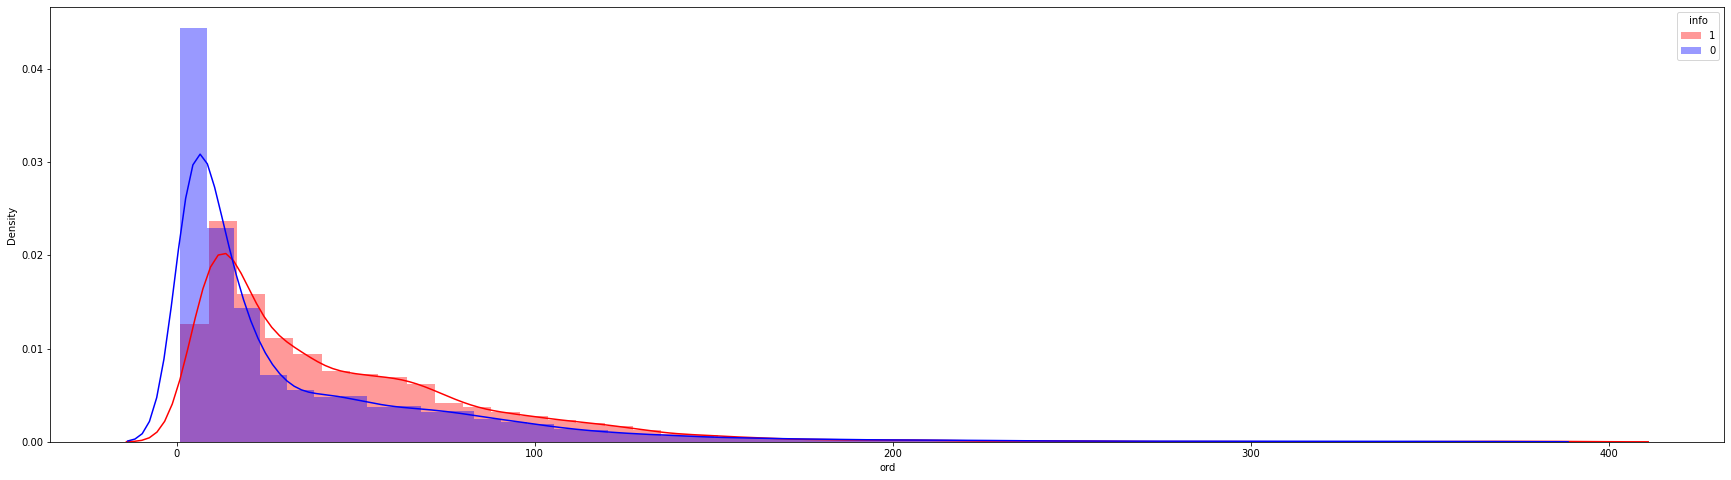

In [ ]:
plt.figure(figsize=(30,8))
sns.distplot(train_csv[train_csv['info'] == 1]['ord'], color = 'red', label='1')
sns.distplot(train_csv[train_csv['info'] == 0]['ord'], color = 'blue', label='0')
plt.legend(title = 'info')

###내가 요일별로 분석해본 것

In [ ]:
lis = []

for day in tmp:
    lis.append(day.weekday())

AttributeError: ignored

In [ ]:
df = pd.DataFrame(data=lis, columns=['day'])

In [ ]:
df = pd.concat([train_csv['info'].copy(), df], axis=1)

In [ ]:
group = df.groupby(['day', 'info'])

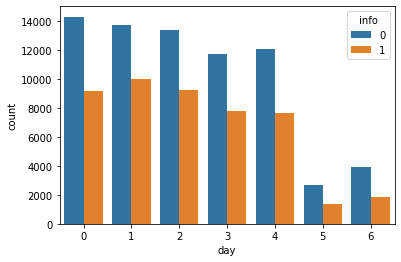

In [ ]:
sns.countplot(data = df, x='day', hue='info')

In [ ]:
print("train_isna : ", end=" ")
for col in train_csv.columns:
    print(np.sum(train_csv[col].isna()), end=" ")
print()
print("test_isna : ", end=" ")
for col in test_csv.columns:
    print(np.sum(test_csv[col].isna()), end=" ")

train_isna :  0 0 0 0 0 0 
test_isna :  0 0 0 0 0 0 

In [ ]:
print("진짜 뉴스 수 : ", len(train_csv.loc[train_csv['info']==0]))
print("가짜 뉴스 수 : ", len(train_csv.loc[train_csv['info']==1]))
print("진짜 뉴스 비율 : ", round(len(train_csv.loc[train_csv['info']==0]) / len(train_csv) * 100, 3))
print("가짜 뉴스 비율 : ", round(len(train_csv.loc[train_csv['info']==1]) / len(train_csv) * 100, 3))

진짜 뉴스 수 :  71813
가짜 뉴스 수 :  46932
진짜 뉴스 비율 :  60.477
가짜 뉴스 비율 :  39.523


In [ ]:
graph = train_csv.loc[train_csv['ord'] < 50]
plt.figure(figsize=(20,10))
sns.countplot(data=graph, x='ord', hue='info')

In [ ]:
#length feature 추가
train_csv['length'] = train_csv['content'].apply(lambda x : len(x))

"""plt.figure(figsize=(12,7))
fake = train_csv.loc[train_csv['info']==1]
truth = train_csv.loc[train_csv['info']==0]
sns.distplot(fake['length'], label="len of fake news")
sns.distplot(truth['length'], label="len of real news")
plt.xlim(0, 200)
plt.legend()"""

'plt.figure(figsize=(12,7))\nfake = train_csv.loc[train_csv[\'info\']==1]\ntruth = train_csv.loc[train_csv[\'info\']==0]\nsns.distplot(fake[\'length\'], label="len of fake news")\nsns.distplot(truth[\'length\'], label="len of real news")\nplt.xlim(0, 200)\nplt.legend()'

In [ ]:
test_csv['length'] = test_csv['content'].apply(lambda x : len(x))

In [ ]:
#중복 확인 및 제거
#train_csv['content'].nunique()
#train_csv.drop_duplicates(subset=['content'], inplace=True)

In [ ]:
test_csv.columns

Index(['n_id', 'date', 'title', 'content', 'ord', 'id', 'length'], dtype='object')

#Dacon + conv1d

In [ ]:
train = train_csv.copy()
test = test_csv.copy()

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 72.4MB/s 
     |████████████████████████████████| 92kB 13.1MB/s 
     |████████████████████████████████| 460kB 55.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0


In [ ]:
!pip install tqdm

In [ ]:
from konlpy.tag import Okt
from tqdm import tqdm

In [ ]:
def text_preprocessing(text_list):
    stopwords = ['을', '를', '이', '가', '은', '는','에', '으로', '부터', 'null']
    tokenizer = Okt()
    token_list = []

    for text in tqdm(text_list):
        text = re.sub('[^가-힣a-z]', ' ', text.lower())
        token = tokenizer.morphs(text, stem=True)
        token = [word for word in token if word not in stopwords or type(word) != float]
        token_list.append(token)

    return token_list, tokenizer

In [ ]:
train['token'], okt = text_preprocessing(train['content'])

100%|██████████| 118745/118745 [05:50<00:00, 339.15it/s]


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def text2sequence(train_text, max_len=100):
    #가장 빈도가 높은 단어 선택하게하는 tokenizer 객체
    vectorizer = Tokenizer()

    #맞는 단어 인덱스 구축
    vectorizer.fit_on_texts(train_text)

    #인덱스의 리스트로 변환
    sequence = vectorizer.texts_to_sequences(train_text)
    vocab_size = len(vectorizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    x_padding = pad_sequences(sequence, maxlen = max_len)

    return x_padding, vocab_size, vectorizer

In [ ]:
train_y =  train['info']
train_padding, vocab_size, vectorizer = text2sequence(train['token'], max_len=100)
train_padding.shape

vocab_size :  32784


(118745, 100)

In [ ]:
#다 0으로 패딩되어 있는 인덱스들
drop_index = np.where((train_padding.sum(axis=1) == 0) == True)

In [ ]:
drop_index = drop_index[0]

In [ ]:
drop_index

array([   584,   4573,   4576,   4577,  11789,  11791,  11793,  11795,
        11797,  11799,  11801,  11803,  11805,  11807,  11809,  11811,
        11813,  11815,  11817,  11819,  11821,  11823,  11825,  11827,
        11829,  11831,  11843,  11845,  11847,  11849,  11851,  11853,
        11855,  11857,  11872,  11874,  11876,  11878,  11880,  11882,
        11884,  11886,  11888,  11890,  11892,  15081,  48006,  48162,
        66948,  66963,  67000,  67015,  67858,  67860,  67862,  67864,
        67866,  67868,  67870,  67872,  67874,  67876,  67902,  67904,
        67906,  67908,  67910,  67912,  67914,  67916,  67918,  67920,
       107285, 107288, 107299, 107307, 107377, 107380, 107391, 107399])

In [ ]:
train_csv.columns

Index(['n_id', 'date', 'title', 'content', 'ord', 'info', 'length'], dtype='object')

In [ ]:
#모두 0으로 패딩된 샘플은 info가 0일 가능성이 크다 (98.75%)
train_csv.iloc[drop_index, 5].sum() / len(drop_index) * 100

1.25

####embedding

In [ ]:
!pip install gensim

In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
import gensim
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300 (1).bin.gz', binary = True)

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
cnt = 0
for index, word in enumerate(vectorizer.word_index):
    if word in word2vec:
        embedding_vector = word2vec[word]
        embedding_matrix[index] = embedding_vector
    else:
        cnt += 1

print(round(cnt/vocab_size*100,3), '%만큼 단어가 존재하지 않습니다.')

91.365  %만큼 단어가 존재하지 않습니다.


In [ ]:
from keras.layers import SpatialDropout1D, Embedding, Conv1D, Dropout, GlobalMaxPool1D, Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
def My_model(vocab_size, max_len = 100):

  inputs = Input(shape=(100,))  
    # embedding layer를 선언
  embedding_layer = keras.layers.Embedding(vocab_size, 300, weights = [embedding_matrix])(inputs)

  # embedding layer에 대한 output에 대해 dropout을 취한다.
  dropout_emb = keras.layers.Dropout(0.5)(embedding_layer)

  ## filters = 128이고 kernel_size = 3,4,5이다.
  ## 길이기ㅏ 3, 4, 5인 128개의 다른 필터를 생성한다. 3, 4, 5 gram의 효과처럼 다양한 각도에서 문장을 보는 효과가 있다.
  ## conv1d는 (배치 크기, 길이, 채널)로 입력값을 받는데, 배치 사이즈 : 문장 숫자 | 길이 : 각 문장의 단어의 개수 | 채널 : 임베딩 출력 차원수

  conv1 = keras.layers.Conv1D(filters=128, kernel_size=3, padding='valid', activation=tf.nn.relu)(dropout_emb)
  pool1 = keras.layers.GlobalMaxPool1D()(conv1)

  conv2 = keras.layers.Conv1D(filters=128, kernel_size=4, padding='valid', activation=tf.nn.relu)(dropout_emb)
  pool2 = keras.layers.GlobalMaxPool1D()(conv2)

  conv3 = keras.layers.Conv1D(filters=128, kernel_size=5, padding='valid', activation=tf.nn.relu)(dropout_emb)
  pool3 = keras.layers.GlobalMaxPool1D()(conv3)

  # 3,4,5 gram이후 모아주기
  concat = keras.layers.concatenate([pool1, pool2, pool3])

  hidden = keras.layers.Dense(250, activation=tf.nn.relu)(concat)
  dropout_hidden = keras.layers.Dropout(0.5)(hidden)
  output = keras.layers.Dense(1, activation='sigmoid')(dropout_hidden)

  model = Model(inputs=[inputs], outputs=[output])
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
model = My_model(vocab_size)

In [ ]:
epochs = 10
batch_size = 32

In [ ]:
train_padding.shape, train_y.shape

((118745, 100), (118745,))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model_second.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.fit(x=train_padding, y=train_y, epochs = epochs, batch_size = batch_size,
          shuffle=True, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
2969/2969 [==============================] - 284s 95ms/step - loss: 0.1508 - accuracy: 0.9354 - val_loss: 0.0867 - val_accuracy: 0.9668
Epoch 2/10
2969/2969 [==============================] - 272s 91ms/step - loss: 0.0304 - accuracy: 0.9897 - val_loss: 0.0650 - val_accuracy: 0.9739
Epoch 3/10
2969/2969 [==============================] - 270s 91ms/step - loss: 0.0111 - accuracy: 0.9962 - val_loss: 0.0731 - val_accuracy: 0.9776
Epoch 4/10
2969/2969 [==============================] - 269s 91ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.1184 - val_accuracy: 0.9757
Epoch 5/10
2969/2969 [==============================] - 269s 91ms/step - loss: 0.0055 - accuracy: 0.9984 - val_loss: 0.1483 - val_accuracy: 0.9707
Epoch 00005: early stopping


In [ ]:
pre_pred = model.predict(train_padding)

In [ ]:
pre_pred

numpy.ndarray

In [ ]:
pre_pred_df = pd.DataFrame(data=pre_pred)

In [ ]:
tmp = pre_pred_df[0].apply(lambda x: 0 if x < 0.5 else 1)

In [ ]:
train_csv['info'].shape

(118745,)

In [ ]:
((tmp == train_csv['info']).values.sum()) / len(train_csv)

0.9936334161438376

In [ ]:
#test preprocessing
stopwords = ['을', '를', '이', '가', '은', '는','에', '으로', '부터', 'null']
token_list = []

for text in tqdm(test_csv['content']):
    text = re.sub('[^가-힣a-z]', ' ', text.lower())
    token = okt.morphs(text, stem=True)
    token = [word for word in token if word not in stopwords or type(word) != float]
    token_list.append(token)

100%|██████████| 142565/142565 [15:22<00:00, 154.56it/s]


In [ ]:
test_sequence = vectorizer.texts_to_sequences(token_list)

In [ ]:
test_padding = pad_sequences(test_sequence, maxlen=100)

In [ ]:
pred = model.predict(test_padding)

In [ ]:
reformed_pred = np.where(pred < 0.5, 0 ,1)

In [ ]:
reformed_pred = pd.DataFrame(data=reformed_pred, columns=['info'])

In [ ]:
reformed_pred.shape, test_csv.shape

((142565, 1), (142565, 7))

In [ ]:
submission_conv1d = submission_csv.drop(['info'], axis=1)
submission_conv1d = pd.concat([submission_conv1d, reformed_pred], axis=1)

In [ ]:
submission_conv1d.head()

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


In [ ]:
submission_conv1d.to_csv('submission_conv1d.csv', index=False)

#Dacon LSTM

In [ ]:
!pip install konlpy

In [ ]:
train = train_csv.copy()
test = test_csv.copy()

In [ ]:
#토큰화
from konlpy.tag import Okt

def text_preprocessing(text_list):
    stopwords = ['을', '를', '이', '가', '은', '는', '에', 'null']
    tokenizer = Okt()
    token_list = []

    for text in text_list:
        txt = re.sub('[^가-힣a-z]', ' ', text.lower())
        token = tokenizer.morphs(txt, stem = True)   #형태소분석
        token = [t for t in token if t not in stopwords or type(t) != float]
        token_list.append(token)

    return token_list, tokenizer

train['token'], okt = text_preprocessing(train['content'])

In [ ]:
print(train['token'].head())
print(train_csv['content'].head())

0           [이데일리, marketpoint, 현재, 코스닥, 기관, 억, 순, 매도]
1    [실적, 기반, 저가, 에, 매집, 하다, 하다, 월, 급등, 유망, 주, top,...
2          [하, 이스, 탁론, 선취, 수수료, 없다, 월, 최저, 금리, 상품, 출시]
3         [종합, 경제, 정보, 미디어, 이데일리, 무단, 전, 재, 재, 배포, 금지]
4                 [전국, 적, 인, 소비, 붐, 조성, 에, 기여, 하다, 예정]
Name: token, dtype: object
0    [이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도
1         "실적기반" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개
2             하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시
3              종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지
4                          전국적인 소비 붐 조성에 기여할 예정
Name: content, dtype: object


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['token'])
print(tokenizer.word_index)

{'하다': 1, '을': 2, '이': 3, '를': 4, '에': 5, '의': 6, '은': 7, '가': 8, '으로': 9, '는': 10, '있다': 11, '한': 12, '로': 13, '되다': 14, '년': 15, '이다': 16, '일': 17, '등': 18, '수': 19, '에서': 20, '종목': 21, '적': 22, '과': 23, '것': 24, '받다': 25, '도': 26, '인': 27, '들': 28, '한국': 29, '주': 30, '대': 31, '다': 32, '가능': 33, '코로나': 34, '월': 35, '와': 36, '하고': 37, '공개': 38, '전': 39, '이상': 40, '추천': 41, '내다': 42, '목표': 43, '투자': 44, '명': 45, '만': 46, '원': 47, '상한': 48, '돼다': 49, '주식': 50, '무료': 51, '거래': 52, '재': 53, '까지': 54, '정부': 55, '고': 56, '바이오': 57, '보다': 58, '대다': 59, '및': 60, '이용': 61, '금리': 62, '관련': 63, '테마': 64, '최저': 65, '부터': 66, '방': 67, '분': 68, '실적': 69, 'top': 70, '평가': 71, '않다': 72, '따르다': 73, '함께': 74, '기자': 75, '시': 76, '수익': 77, '안': 78, '탁론': 79, '경제': 80, '배': 81, '업계': 82, '저': 83, '기업': 84, '위': 85, '자': 86, '신용': 87, '밝히다': 88, '카톡': 89, '억원': 90, '만들다': 91, '말': 92, '주다': 93, '효과': 94, '중': 95, '급등': 96, '환': 97, '오늘': 98, '없다': 99, '위해': 100, '미수': 101, '혜주': 102, '정책': 103, '당장': 104, 

In [ ]:
#희귀 단어 비율(thredshold 이하로 나타나는 단어)
threshold = 3
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0
cnt = 0

for key, value in tokenizer.word_counts.items():    #(word, cnts)
    total_freq += value

    if(value < threshold):
        rare_cnt += 1
        rare_freq += value
        if(cnt < 5):
            print("word : ", key, value);
            cnt += 1

print(total_cnt, rare_cnt, rare_cnt/total_cnt, rare_freq / total_freq)

word :  ns 1
word :  홈앤쇼핑 2
word :  sb 1
word :  station 1
word :  break 1
32783 12346 0.376597626818778 0.006980600559813443


In [ ]:
vocab_size = total_cnt - rare_cnt + 2
vocab_size

20439

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(train['token'])
train['token'] = tokenizer.texts_to_sequences(train['token'])

In [ ]:
#빈 샘플 제거
drop_train = [index for index, sentence in enumerate(train['token']) if len(sentence) < 1]

In [ ]:
print(max(len(i) for i in train['token']))

1069


In [ ]:
x_train = train.drop(drop_train).copy()
print("사라지고 남은 샘플 수 :", len(x_train))

사라지고 남은 샘플 수 : 118665


18.76253318164581


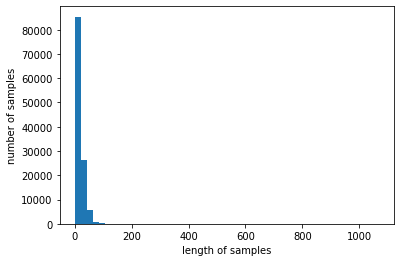

In [ ]:
print(sum(map(len, x_train['token']))/len(x_train))
plt.hist([len(s) for s in x_train['token']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt += 1
    print("전체 중 길이가 %s 이하인 샘플의 비율 : %s"%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 50
below_threshold_len(max_len, x_train['token'])

전체 중 길이가 50 이하인 샘플의 비율 : 96.79686512451018


In [ ]:
train_input = pad_sequences(x_train['token'], maxlen=max_len)

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
y_train =  x_train['info']

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_input, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1583/1583 [==============================] - 24s 13ms/step - loss: 0.1543 - acc: 0.9341 - val_loss: 0.0349 - val_acc: 0.9833

Epoch 00001: val_acc improved from -inf to 0.98331, saving model to best_model.h5
Epoch 2/15
1583/1583 [==============================] - 22s 14ms/step - loss: 0.0571 - acc: 0.9794 - val_loss: 0.0327 - val_acc: 0.9848

Epoch 00002: val_acc improved from 0.98331 to 0.98483, saving model to best_model.h5
Epoch 3/15
1583/1583 [==============================] - 22s 14ms/step - loss: 0.0442 - acc: 0.9839 - val_loss: 0.0344 - val_acc: 0.9857

Epoch 00003: val_acc improved from 0.98483 to 0.98567, saving model to best_model.h5
Epoch 4/15
1583/1583 [==============================] - 22s 14ms/step - loss: 0.0343 - acc: 0.9879 - val_loss: 0.0584 - val_acc: 0.9744

Epoch 00004: val_acc did not improve from 0.98567
Epoch 5/15
1583/1583 [==============================] - 22s 14ms/step - loss: 0.0269 - acc: 0.9901 - val_loss: 0.0508 - val_acc: 0.9776

Epoch 00005: 

In [ ]:
loaded_model = load_model('best_model.h5')

In [ ]:
y_train.shape, x_train.shape, train_input.shape, lstm_pred.shape

((118665,), (118665, 8), (118665, 50), (118665, 1))

In [ ]:
lstm_pred = loaded_model.predict(train_input)

In [ ]:
print(x_train.shape)
print(pd.DataFrame(lstm_pred).shape)
print(pd.concat([x_train.reset_index(drop=True), pd.DataFrame(lstm_pred)], axis=1).shape)

(118665, 8)
(118665, 1)
(118665, 9)


In [ ]:
#x_train이 index드롭을 해서 인덱스가 맞지않은데, concat은 인덱스 기준으로 연결함. 그래서 reset 필요
x_input = pd.concat([x_train.reset_index(drop=True), pd.DataFrame(lstm_pred, columns=['prev_pred'])], axis=1)

In [ ]:
x_input = x_input.drop(['n_id', 'title', 'content', 'token', 'info'], axis=1) #ord 여부도 확인

In [ ]:
x_input

,date,ord,length,prev_pred
0,20200605,1,42,0.008673
1,20200605,2,37,0.999990
2,20200605,3,33,0.999908
3,20200605,4,32,0.000026
4,20200626,1,20,0.003419
...,...,...,...,...
118660,20200117,48,35,0.999972
118661,20200117,49,23,0.999981
118662,20200117,50,23,0.999981
118663,20200117,51,27,0.999804


In [ ]:
y_train = x_train['info']

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_input, y_train)

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((88998, 4), (29667, 4), (88998,), (29667,))

In [ ]:
x_train['date'] -= 20200000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
x_train

,date,ord,length,prev_pred
110405,513,25,137,0.007524
118191,403,11,52,0.000392
57000,525,64,32,0.999975
92778,109,30,23,0.999981
56462,410,126,32,0.999975
...,...,...,...,...
64810,113,34,39,0.999931
18702,511,24,15,0.988747
89817,527,13,37,0.999952
10193,326,6,113,0.001376


In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100)
model = model.fit(x_train, y_train)

In [ ]:
print("train 점수 : ", model.score(x_train, y_train))
print("test점수 : ", model.score(x_test, y_test))

train 점수 :  1.0
test점수 :  0.9911349310681903


In [ ]:
model = model.fit(x_test, y_test)

#####testset 전처리

In [ ]:
test_csv.isnull().values.any()

False

In [ ]:
def test_preprocessing(new_list):
    stopwords = ['을', '를', '이', '가', '은', '는', '에', 'null']
    res = []
    for sentence in new_list:
        sentence = re.sub('[^가-힣a-z]', ' ', sentence.lower()) #특수문자, 숫자 등 제거
        sentence = okt.morphs(sentence, stem=True)  #형태소 분석
        sentence = [word for word in sentence if not word in stopwords] #불용어 제거
        encoded = tokenizer.texts_to_sequences([sentence])  #정수화
        res.append(encoded)

    return res

In [ ]:
test_res = pd.DataFrame(data=test_preprocessing(test['content']), columns=['token'])

In [ ]:
#길이 0인거
index = 0
drop_test=[]
for sentence in test_res['token']:
    if(len(sentence)<1):
        drop_test.append(index)
    index += 1

In [ ]:
drop_test[:5]

[3917, 29937, 31326, 32535, 33511]

In [ ]:
sum(train_csv.iloc[drop_train, 5])  #len이 1이하인거는 다 0으로 판별하는것이 좋음을 train을 통해 알 수 있음

1

In [ ]:
test_padding = test_res.drop(drop_test)

In [ ]:
test_padding.head()

,token
0,"[3670, 3016, 109, 717, 2329, 3155, 5848, 293, ..."
1,"[305, 1, 76, 814, 717, 293, 1, 115, 7, 223, 65..."
2,"[171, 983, 293, 29, 24, 53, 1824, 64, 717, 29,..."
3,"[109, 3609, 422, 14, 197, 67, 3670, 3016, 7, 1..."
4,"[1, 814, 717, 1192, 280, 2, 293, 14, 157, 16, ..."


In [ ]:
test_padding = pad_sequences(test_padding['token'], maxlen=50)

In [ ]:
test_padding.shape

(142467, 50)

In [ ]:
pre_pred = loaded_model.predict(test_padding)

In [ ]:
x_test = test.drop(drop_test)
x_test_input = pd.concat([x_test.reset_index(drop=True), pd.DataFrame(pre_pred, columns=['pre_pred'])], axis=1)

In [ ]:
x_test_input.shape

(142467, 8)

In [ ]:
x_test_input.columns

Index(['n_id', 'date', 'title', 'content', 'ord', 'id', 'length', 'pre_pred'], dtype='object')

In [ ]:
x_test_input.drop(['n_id','title','content', 'id'], axis=1, inplace=True)

In [ ]:
x_test_input['date'] -= 20200000

In [ ]:
x_test_input.head()

,date,ord,length,pre_pred
0,118,1,48,0.561077
1,118,2,76,0.003904
2,118,3,56,0.002353
3,118,4,76,0.002047
4,118,5,102,0.002509


In [ ]:
x_test_input.isna().any()

date        False
ord         False
length      False
pre_pred    False
dtype: bool

In [ ]:
fianl_pred = model.predict(x_test_input)

In [ ]:
type(fianl_pred)

numpy.ndarray

In [ ]:
final_csv = submission_csv.copy()

In [ ]:
final_csv.head()

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


In [ ]:
j = 0
for i in range(0,len(final_csv)):
    if(j not in drop_test):
        final_csv['info'][i] = fianl_pred[j]
        j += 1
    else:
        final_csv['info'][i] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
final_csv.loc[:, ["id", "info"]].to_csv("submission_lstm_randomforest.csv",index=False)

###dacon내용

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def text2sequence(train_text, max_len=100):
    tokenizer = Tokenizer() #vectorizing 함수
    tokenizer.fit_on_texts(train_text)  #각 단어에 점수 부여
    train_x_seq = tokenizer.texts_to_sequences(train_text)  #각 토큰들에 정수부여
    vocab_size = len(tokenizer.word_index) + 1
    print('vocab_size : ', vocab_size)
    x_train = pad_sequences(train_x_seq, maxlen = max_len)  #padding

    return x_train, vocab_size, tokenizer

train_x, vocac_size, vectorizer = text2sequence(train['token'], max_len=100)

vocab_size :  44851


In [ ]:
type(train_x)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

In [ ]:
def LSTM(vocab_size, max_len=100):
    model = Sequential()
    model.add(Embedding(vocab_size, 128))
    model.add(SpatialDropout1D(0.3))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')
    model.summary()

    return model

In [ ]:
train
model = LSTM(vocab_size)
model.fit(train_x, train_csv['info'],
          batch_size=batch_size,
          epochs=15,
          )

#AutoML

In [ ]:
!pip install autokeras
#!pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc4

In [ ]:
import autokeras as ak

In [ ]:
train_cont = train_csv.content.values   #numpy
train_y = train_csv['info'].values      #numpy

In [ ]:
input_node = ak.TextInput()
output_node = ak.TextToIntSequence()(input_node)
output_node = ak.Embedding()(output_node)
output_node = ak.ConvBlock(separable=True)(output_node)
output_node = ak.ClassificationHead()(output_node)

clf = ak.AutoModel(
    inputs=input_node,
    outputs = output_node,
    overwrite = True,
    max_trials = 5
)
clf.fit(train_cont, train_y, epochs=3)
model = clf.export_model()

Trial 5 Complete [00h 09m 01s]
val_loss: 0.003356833243742585

Best val_loss So Far: 0.0026177221443504095
Total elapsed time: 00h 43m 18s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
3711/3711 [==============================] - 119s 32ms/step - loss: 0.1118 - accuracy: 0.9553
Epoch 2/5
3711/3711 [==============================] - 118s 32ms/step - loss: 0.0455 - accuracy: 0.9839
Epoch 3/5
3711/3711 [==============================] - 120s 32ms/step - loss: 0.0267 - accuracy: 0.9902
Epoch 4/5
3711/3711 [==============================] - 120s 32ms/step - loss: 0.0174 - accuracy: 0.9936
Epoch 5/5
3711/3711 [==============================] - 119s 32ms/step - loss: 0.0115 - accuracy: 0.9958
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [ ]:
model.summary()

In [ ]:
pred_test = model.predict(test_csv.content.values)
submission_csv.loc[:, 'info'] = np.where(pred_test>0.5, 1,0).reshape(-1)

In [ ]:
submission_csv.loc[:,["id", "info"]].to_csv("sample_submission.csv", index=False)

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


In [ ]:
#모델 저장
from tensorflow import keras
from keras.models import load_model
model.save('AInews_auto_model')

INFO:tensorflow:Assets written to: AInews_auto_model/assets


### 2

In [ ]:
!pip install pycaret

In [ ]:
from pycaret.classification import *

In [ ]:
os.chdir("/content/drive/MyDrive/Dacon/AInews")

In [ ]:
os.getcwd()

'/content/drive/My Drive/Dacon/AInews'

In [ ]:
#모델 가져오기
from keras.models import load_model
import autokeras as ak
model = load_model("AInews_auto_model", custom_objects=ak.CUSTOM_OBJECTS)

In [ ]:
#모델 가져온거 예측
predict_target = model.predict(train_csv.content.values)

In [ ]:
predict_target.shape

(118745, 1)

In [ ]:
train_csv.columns

Index(['n_id', 'date', 'title', 'content', 'ord', 'info', 'length'], dtype='object')

In [ ]:
#preprocessing (drop)
train = train_csv.drop(["title", "n_id", "content"], axis=1)
train['pre_target'] = predict_target

In [ ]:
train

,date,ord,info,length,pre_target
0,20200605,1,0,42,2.314312e-13
1,20200605,2,1,37,9.999919e-01
2,20200605,3,1,33,9.998140e-01
3,20200605,4,0,32,2.023665e-30
4,20200626,1,0,20,9.292672e-06
...,...,...,...,...,...
118740,20200117,48,1,35,1.000000e+00
118741,20200117,49,1,23,1.000000e+00
118742,20200117,50,1,23,1.000000e+00
118743,20200117,51,1,27,1.000000e+00


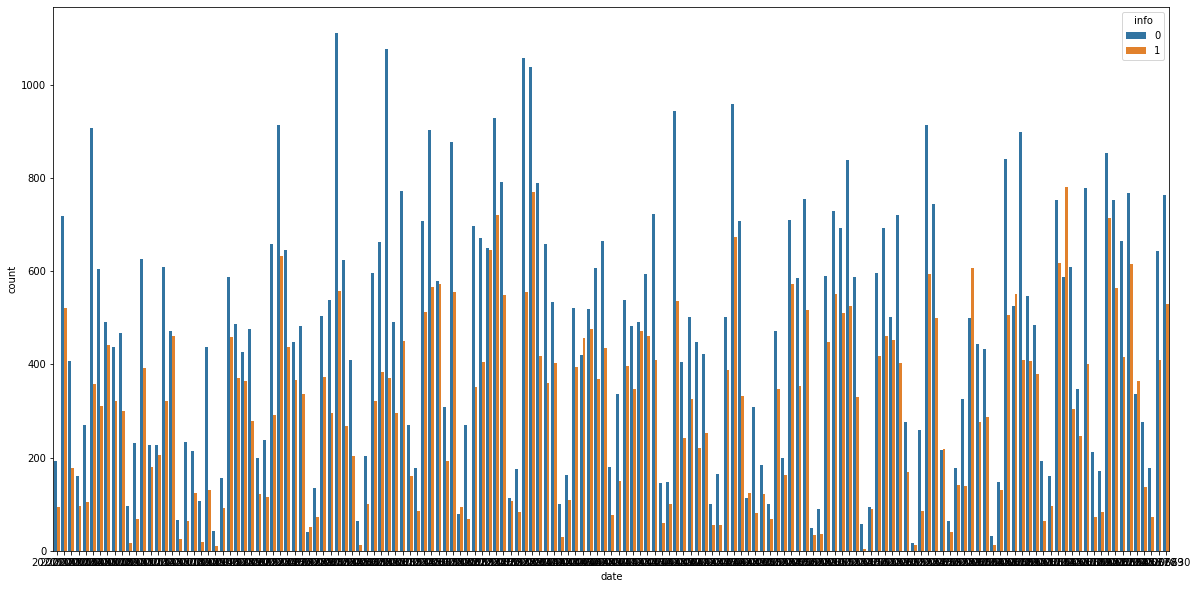

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(data = train_csv[['date', 'info']], x='date', hue='info')

In [ ]:
clf = setup(data = train, target = 'info')

In [ ]:
best_3 = compare_models(sort = 'Accuracy', n_select=3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9927,0.9994,0.9891,0.9926,0.9908,0.9848,0.9848,4.641
xgboost,Extreme Gradient Boosting,0.9927,0.9997,0.9899,0.9917,0.9908,0.9847,0.9847,7.816
et,Extra Trees Classifier,0.9925,0.9995,0.9890,0.9920,0.9905,0.9843,0.9843,2.829
lightgbm,Light Gradient Boosting Machine,0.9917,0.9997,0.9896,0.9894,0.9895,0.9826,0.9826,0.574
catboost,CatBoost Classifier,0.9915,0.9997,0.9888,0.9896,0.9892,0.9821,0.9821,25.534
gbc,Gradient Boosting Classifier,0.9908,0.9996,0.9874,0.9894,0.9884,0.9808,0.9808,4.876
dt,Decision Tree Classifier,0.9893,0.9888,0.9865,0.9864,0.9865,0.9776,0.9776,0.181
ada,Ada Boost Classifier,0.9890,0.9995,0.9842,0.9881,0.9861,0.9770,0.9770,1.611
qda,Quadratic Discriminant Analysis,0.9794,0.9940,0.9664,0.9813,0.9738,0.9568,0.9568,0.075
nb,Naive Bayes,0.9785,0.9929,0.9635,0.9818,0.9725,0.9548,0.9549,0.069


In [ ]:
blended = blend_models(estimator_list = best_3, fold = 5, method='hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9922,0.0,0.9880,0.9924,0.9902,0.9838,0.9838
1,0.9930,0.0,0.9888,0.9934,0.9911,0.9853,0.9853
2,0.9934,0.0,0.9909,0.9924,0.9916,0.9862,0.9862
3,0.9925,0.0,0.9901,0.9909,0.9905,0.9843,0.9843
4,0.9933,0.0,0.9889,0.9940,0.9915,0.9859,0.9859
Mean,0.9929,0.0,0.9893,0.9926,0.9910,0.9851,0.9851
SD,0.0004,0.0,0.0010,0.0011,0.0006,0.0009,0.0009


In [ ]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.9925,0.9918,0.9887,0.9921,0.9904,0.9842,0.9842


In [ ]:
final_model = finalize_model(blended)

##Test (auto->auto)

In [ ]:
pred_test = model.predict(test_csv.content.values)

In [ ]:
pred_test.shape

(142565, 1)

In [ ]:
test_csv.columns

Index(['n_id', 'date', 'title', 'content', 'ord', 'id'], dtype='object')

In [ ]:
train_csv['length'] = train_csv['content'].apply(lambda x : len(x))

In [ ]:
test_2nd_input = test_csv.drop(["n_id", "title", "content", "id"],axis=1)
test_2nd_input['length'] = test_csv['content'].apply(lambda x : len(x))
test_2nd_input['pre_target'] = pred_test

In [ ]:
test_2nd_input.head()

,date,ord,length,pre_target
0,20200118,1,48,9.014326e-10
1,20200118,2,76,1.758290e-16
2,20200118,3,56,2.487765e-11
3,20200118,4,76,1.613616e-11
4,20200118,5,102,2.195861e-17


In [ ]:
prediction = predict_model(final_model, data = test_2nd_input)

In [ ]:
prediction

,date,ord,length,pre_target,Label
0,20200118,1,48,9.014326e-10,0
1,20200118,2,76,1.758290e-16,0
2,20200118,3,56,2.487765e-11,0
3,20200118,4,76,1.613616e-11,0
4,20200118,5,102,2.195861e-17,0
...,...,...,...,...,...
142560,20200521,72,35,1.000000e+00,1
142561,20200521,73,23,1.000000e+00,1
142562,20200521,74,23,1.000000e+00,1
142563,20200521,75,27,1.000000e+00,1


In [ ]:
submission_csv.loc[:,"info"] = prediction.loc[:,"Label"]

In [ ]:
submission_csv.loc[:,["id","info"]].to_csv("submission2.csv",index=False)

#sth else

In [ ]:
#결과 비교 함수
def cmp_result(old, new):
    tmp = pd.concat([old['info'], new['info']], axis=1, keys=["o_info", "n_info"])
    print(round(len(tmp.loc[tmp['o_info']==tmp['n_info']]) / len(tmp) * 100,3))

In [ ]:
cmp_result(pd.read_csv(file_dir+"/submission2.csv"), submission_conv1d)

95.284


In [ ]:
cmp_result(sample, pd.read_csv(file_dir + "/submission2.csv"))

93.347


#dacon Bert

In [ ]:
!pip install keras-bert

  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp36-none-any.whl size=34145 sha256=f511409ac86051fcab18a61f02bc8afc506cba01f8b0aef6269ce1eb84759736
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp36-none-any.whl size=12944 sha256=03f541d920430e8015a2503bf0e0f2d05a28e974dd151d523843bac4a79e79a6
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7553 sha256=8fde3164a5946d20c2d5a49bec0786cfa962310cdb00b75579c6c8d63e1bf5a1
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp36-none-any.whl size=15612 sha256=f62bfc0724f93f2fb407557aa8f1564a17680812108e98bf4061965aa132ad4b
  Stor

In [ ]:
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model, optimizers

import codecs
from tqdm import tqdm
import shutil

In [ ]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

In [ ]:
def copytree(src, dst, symlinks=False, ignore = None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/AI야, 진짜 뉴스를 찾아줘!'

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
SEQ_LEN = 128
batch_size = 16
epochs = 3
lr = 1e-5

config_path = os.path.join(path, 'bert_config.json')
checkpoint_path = os.path.join(path, 'bert_model.ckpt')
vaocab_path = os.path.join(path, 'vocab.txt')

data_col = 'content'
label_col = 'info'

In [ ]:
token_dict = {}

with codecs.open(vaocab_path, 'r', encoding='utf-8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
            token = token.replace("-", "")
            token = "##" + token
        token_dict[token] = len(token_dict)

In [ ]:
token_dict

In [ ]:
#위의 tokenizer를 그대로 사용하면 자모분리가 되어 tokenizer를 상속하여 정의

class inherit_Tokenizer(Tokenizer):
    def _tokenize(self, text):
        if not self._cased:
            text = text

            text = text.lower()
        
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            else:
                spaced += ch
            
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [ ]:
tokenizer = inherit_Tokenizer(token_dict)

In [ ]:
tokenizer.tokenize('이거 어떻게 하는 걸까?')

['[CLS]', '이', '##거', '어', '##떻', '##게', '하', '##는', '걸', '##까', '?', '[SEP]']

In [ ]:
tokenizer.encode(test_csv[data_col][0])

In [ ]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[data_col][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[label_col][i])

    items = list(zip(indices, targets))

    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[data_col] = data_df[data_col].astype(str)

    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [ ]:
train_x, train_y = load_data(train_csv)

100%|██████████| 118745/118745 [00:15<00:00, 7564.90it/s]


In [ ]:
train_x

BERT의 Input은 Token + Segment + Position으로 정해짐

Token은 train_x[0]이고 Segement은 train_x[1]임

Seg는 앞문장 / 뒷문장 구분해주는 역할을 함 fine-tuning을 하기 때문에 모두 0으로 매칭이 됨(뒤에 문장은 안씀) Position은 Bert내에서 Position Embedding이 automatically 됨

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)

    items = indices
    indices= np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):
    data_x = sentence_convert_data(sentences)
    return data_x

In [ ]:
sentence_load_data(['이게 왜 이제서야 될까', '눈 아프다'])

In [ ]:
#모델
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training = True,
    trainable = True,
    seq_len = SEQ_LEN
)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
def get_bert_finetuning_model(model):
    inputs = model.inputs[:2]
    dense = model.layers[-3].output

    outputs = keras.layers.Dense(1, activation= 'sigmoid', kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                                 name = 'real_output')(dense)
    bert_model = keras.models.Model(inputs, outputs)
    Adam = keras.optimizers.Adam(lr=0.00001)
    bert_model.compile(
        optimizer = Adam,
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )

    return bert_model

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot

In [ ]:
SVG(model_to_dot(get_bert_finetuning_model(model), dpi = 65).create(prog='dot', format='svg'))

In [ ]:
bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=8, batch_size=16, verbose=1, shuffle = False)
bert_model.save_weights(path+ '/bert1.h5')

Epoch 1/8
7422/7422 [==============================] - 4782s 642ms/step - loss: 0.1359 - accuracy: 0.9474
Epoch 2/8
7422/7422 [==============================] - 4782s 644ms/step - loss: 0.1006 - accuracy: 0.9650
Epoch 3/8
7422/7422 [==============================] - 4698s 633ms/step - loss: 0.0757 - accuracy: 0.9720
Epoch 4/8
7422/7422 [==============================] - 4698s 633ms/step - loss: 0.0621 - accuracy: 0.9766
Epoch 5/8
 527/7422 [=>............................] - ETA: 1:13:09 - loss: 0.0893 - accuracy: 0.9764

KeyboardInterrupt: ignored